# 10 階層ベイズモデル -GLMMのベイズモデル化-

In [20]:
using CSV
using DataFrames
using Distributions
using ForneyLab
using Mamba
using Plots
using QuadGK
using StatsBase
using StatsFuns

## 10.1 例題 : 個体差と生存種子数 (個体差あり)

In [2]:
df = CSV.read("data/section10.csv")
disallowmissing!(df)

,id,y
,Int64,Int64
1,1,0
2,2,2
3,3,7
4,4,8
5,5,1
6,6,7
7,7,8
8,8,8
9,9,1


青丸は観測データ、白丸は生存確率0.504の二項分布

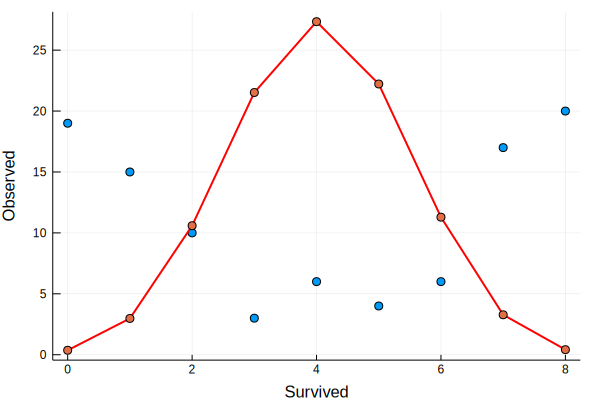

In [3]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
ys = pdf.(Binomial(8, 0.504), 0:8) .* 100
plot!(0:8, ys, linecolor = :red, linewidth = 2,
    marker = 4, label = "",
    xlabel = "Survived", ylabel = "Observed")

## 10.3 階層ベイズモデルの推定・予測
### 10.3.1 階層ベイズモデルのMCMCサンプリング

In [4]:
model = Model(
    y = Stochastic(1,
        (beta, r, N) ->
            UnivariateDistribution[
                (q = invlogit(beta + r[i]);
                Binomial(8, q)) for i in 1:N
            ],
        false
    ),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, N) -> 
            UnivariateDistribution[
                Normal(0, s) for i in 1:N
            ],
        false
    ),
    
    s = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


### モデルの図示

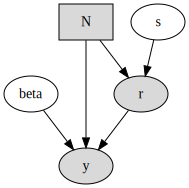

In [5]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

### MCMCサンプリング

In [6]:
data = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 100
  :y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0]

In [7]:
inits = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.0294881, -0.0639144, -0.0507042, 0.00782865, -0.0262745, -0.0591087, -0.111436, -0.0147869, 0.0643883, 0.0207172  …  -0.154372, -0.0843905, -0.0309074, 0.0838536, -0.151418, -0.127431, -0.21374, -0.135667, -0.0361124, 0.0522049])
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.0231103, 0.0544899, -0.0501537, -0.0179194, -0.0371875, -0.190671, -0.00914688, 0.184954, -0.0703542, 0.0739677  …  -0.00916059, 0.0575389, -0.0841948, 0.151661, 0.0698532, 0.0176921, 0.175112, -0.0118471, -0.108149, -0.0947877])
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[-0.118341, 0.167788, 0.0804606, -0.102809, 0.143872, 0.035743, -0.0746841, -0.0121702, 0.166389, 0.101691  …  0.0863748, -0.00616134, 0.0645315, 0.135076, -0.208513, -0.00331306, -0.021196, -0.0564102, -0.

In [8]:
scheme = [
    Slice(:s, 1.0, Mamba.Univariate),
    Slice(:beta, 1.0, Mamba.Univariate),
    AMWG(:r, 1),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                                           
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                   

In [9]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 20000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 20000 Iterations x 3 Chains...

Chain 1:   0% [0:43:11 of 0:43:12 remaining]
Chain 1:  10% [0:02:01 of 0:02:14 remaining]
Chain 1:  20% [0:01:39 of 0:02:03 remaining]
Chain 1:  30% [0:01:23 of 0:01:59 remaining]
Chain 1:  40% [0:01:10 of 0:01:57 remaining]
Chain 1:  50% [0:00:58 of 0:01:56 remaining]
Chain 1:  60% [0:00:47 of 0:01:57 remaining]
Chain 1:  70% [0:00:35 of 0:01:57 remaining]
Chain 1:  80% [0:00:23 of 0:01:57 remaining]
Chain 1:  90% [0:00:12 of 0:01:57 remaining]
Chain 1: 100% [0:00:00 of 0:01:57 remaining]

Chain 2:   0% [0:01:57 of 0:01:57 remaining]
Chain 2:  10% [0:01:50 of 0:02:02 remaining]
Chain 2:  20% [0:01:34 of 0:01:58 remaining]
Chain 2:  30% [0:01:23 of 0:01:59 remaining]
Chain 2:  40% [0:01:11 of 0:01:59 remaining]
Chain 2:  50% [0:00:59 of 0:01:58 remaining]
Chain 2:  60% [0:00:47 of 0:01:58 remaining]
Chain 2:  70% [0:00:35 of 0:01:58 remaining]
Chain 2:  80% [0:00:24 of 0:01:58 remaining]
Chain 2:  90% [0:00:12 of 0:01:58 remaining]
Cha

Object of type "ModelChains"

Iterations = 1010:20000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1900

[2.48109 0.0530203; 2.73986 -0.158438; … ; 2.47937 0.159695; 2.95165 -0.302976]

[3.29634 1.02461; 2.61114 0.905597; … ; 2.58856 -0.0779836; 2.5928 -0.23279]

[3.35312 0.0117628; 3.30057 0.251424; … ; 2.91149 -0.476878; 3.48331 -0.572541]

### サンプリング結果を表示

In [10]:
describe(sim)

Iterations = 1010:20000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1900

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE       ESS   
   s 3.026692871 0.36303465 0.0048085114 0.007461097 1900.0000
beta 0.039358207 0.34345229 0.0045491367 0.011291687  925.1565

Quantiles:
        2.5%       25.0%       50.0%       75.0%      97.5%  
   s  2.3921777  2.76804875 3.000607451 3.25382527 3.81256772
beta -0.6359567 -0.19286140 0.042943772 0.27484762 0.69697253



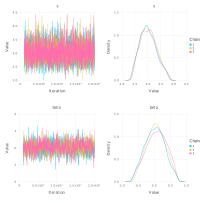

In [11]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

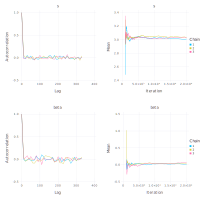

In [12]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

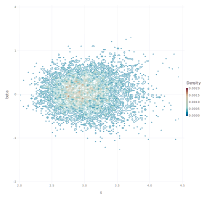

In [13]:
p = Mamba.plot(sim, :contour)
Mamba.draw(p, nrow = 1, ncol = 1)

### 10.3.2 階層ベイズモデルの事後分布推定と予測

In [14]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
   pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end

f_gaussian_binorm (generic function with 1 method)

In [15]:
function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

各パスに対し, $y = 0, \cdots, 8$ に対して $p(y \mid \beta, s)$ を評価する.

In [16]:
posterior = map((x, y) -> d_gaussian_binorm.(0:8, x, y), sim[:, [:beta], :].value[:], sim[:, [:s], :].value[:])

5700-element Array{Array{Float64,1},1}:
 [0.172821, 0.11211, 0.0890117, 0.0794334, 0.0769305, 0.0801543, 0.0907441, 0.115867, 0.182928]  
 [0.212341, 0.115297, 0.0856774, 0.0738703, 0.0701005, 0.0722237, 0.081638, 0.106053, 0.182799]  
 [0.231034, 0.118819, 0.0862642, 0.0732937, 0.0687698, 0.07015, 0.0785268, 0.100955, 0.172188]   
 [0.230751, 0.102938, 0.0732004, 0.0624789, 0.0596004, 0.0625237, 0.0733138, 0.10322, 0.231974]  
 [0.200682, 0.109761, 0.0824121, 0.0717912, 0.0688723, 0.0718567, 0.0825735, 0.110134, 0.201917] 
 [0.216964, 0.0951571, 0.0681, 0.0586877, 0.0566391, 0.0602967, 0.0721959, 0.105541, 0.266418]   
 [0.194669, 0.110208, 0.0836563, 0.0732257, 0.0703943, 0.0734525, 0.0842123, 0.111478, 0.198704] 
 [0.234557, 0.0973016, 0.0683147, 0.0582093, 0.0557003, 0.0588612, 0.0699786, 0.101552, 0.255525]
 [0.230126, 0.0948575, 0.0667206, 0.0570142, 0.0547474, 0.0581105, 0.0695251, 0.10207, 0.266829] 
 [0.167923, 0.0890545, 0.0680767, 0.0609224, 0.0604002, 0.0657028, 0.0801021, 

In [17]:
population_samples = hcat(map(x -> fit(Histogram, rand(Distributions.Categorical(x), 100) .- 1, 0:9).weights, posterior)...)

9×5700 Array{Int64,2}:
 21  26  22  25  24  22  17  17  25  …  22  35  29  19  21  24  23  32  33
 12   9   9  13  11   7  13  12   8     14   9   8  19  11  14   5  15   6
  8   3  15   3   8   7  12   6   7     12   3   7   8   6   8  10   8  11
  5  12  11   3   9  10  11   9   2      8   8   9   7   5   6   7   5   9
  8   5   8   8   6   7   3   5   2      5   6   6   8   8   7   5   7   6
 10   8   8   6   3   6   7  10   6  …   6   6   9   6   4  10   4  10   6
 13  12   2  10  11   6   7   4   9      9   4   4   6   8   8   8   6   6
  8  11  14  10  12   7  16  13  10      7  10   6  17  13  10  14   7  10
 15  14  11  22  16  28  14  24  31     17  19  22  10  24  13  24  10  13

In [18]:
function quantile_sample(r)
    map(x -> quantile(population_samples[x, :], r), 1:9)
end
quantile_sample_0025 = quantile_sample(0.025)
quantile_sample_0975 = quantile_sample(0.975)
quantile_sample_median = quantile_sample(0.5)

9-element Array{Float64,1}:
 21.0
 10.0
  8.0
  7.0
  6.0
  7.0
  8.0
 11.0
 22.0

### 生存種子数の予測分布
各 $y$ における中央値, 及び95%区間の領域を表示する

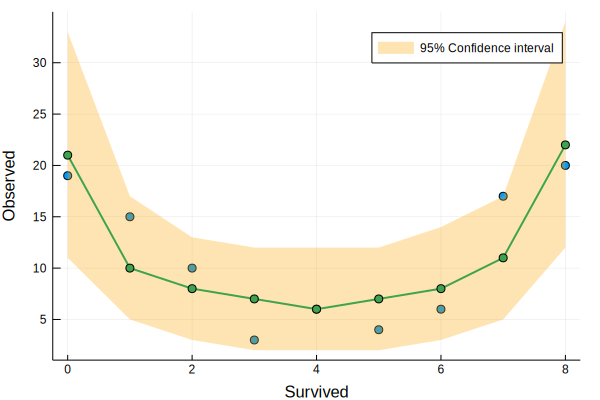

In [21]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
Plots.plot!(0:8, quantile_sample_0025, lw = 0, 
    fillrange = quantile_sample_0975,
    fillalpha = 0.3, fillcolor = :orange,
    label = "95% Confidence interval")
Plots.plot!(0:8, quantile_sample_median, linewidth = 2, marker = 4, label = "",
            xlabel = "Survived", ylabel = "Observed")